In [1]:
!pip install transformers
#!pip install tensorboard


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.2 MB/s 
     |████████████████████████████████| 596 kB 60.8 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 6.6 MB 48.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:

import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

from transformers import (
    DistilBertTokenizer,
    TFDistilBertModel,    
    DataCollatorWithPadding,
    BertTokenizer,
    TFBertModel
)

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

from tqdm.notebook import tqdm
import itertools
import multiprocessing
import os
import matplotlib.pyplot as plt
import seaborn as sns

print("Tensorflow ", tf.__version__)
n_gpus = len(tf.config.list_physical_devices('GPU'))
print("#GPUs: ", n_gpus)
if n_gpus > 0:
    !nvidia-smi -L
os.environ["TOKENIZERS_PARALLELISM"] = "true"

np.random.seed(987654321)
tf.random.set_seed(987654321)

Tensorflow  2.8.0
#GPUs:  1
GPU 0: Tesla T4 (UUID: GPU-8ad872fb-c51a-c681-fa79-6ea9f9983762)


In [3]:
vocab_size = 30000
hide_most_frequently = 0

review_len = 627 # à modifier selon la longueur des posts

epochs = 5
batch_size = 10

fit_verbosity = 1

n_cpus = 1
distil = True #on utilise distilbert plutot que Bert

Import et cleaning des données

In [4]:
#importation des données au format csv content\tnote
#note = 1 si note du fichier json 1 ou 2, sinon 0 (pas pertinent)
from google.colab import drive
drive.mount("/content/drive")
import pandas as pd



Mounted at /content/drive


In [5]:
#import datas from csv made by mongocompass on the 1300 documents 
docs=pd.read_csv('/content/drive/My Drive/LinkedInPosts_20220521_2.csv', sep=',', names=["authors","content","index","note"],encoding='utf-8', header=1, index_col="index")

print(docs)
print(docs.columns)
#cleaning when note or content is empty
docs.dropna(subset=['content'], inplace=True)
docs.dropna(subset=['note'], inplace=True)
print(len(docs))
print(docs.head())

#delete ungraded docs
indexNames = docs[docs['note'] == 0].index 
# Delete these row indexes from dataFrame
docs.drop(indexNames , inplace=True)
print(len(docs))

docs = docs.drop(['authors'], axis=1) #remove authors columns
print(len(docs))

#separate in 2 classes 
docs.loc[docs["note"] == 2.0, "note"] = 1
docs.loc[docs["note"] == 3.0, "note"] = 0
docs.loc[docs["note"] == 4.0, "note"] = 0
print(len(docs))
print(docs.head())

                       authors  \
index                            
2                          NaN   
3      Mahabubur Rahman, Ph.D.   
4                 Anne Gilbert   
5              Alice IUFP_USMB   
6                          NaN   
...                        ...   
1433                       NaN   
1434           Nicolas Breyton   
1435           Nicolas Breyton   
1436           Nicolas Breyton   
1437           Nicolas Breyton   

                                                 content  note  
index                                                           
2                                                    NaN   3.0  
3      Some industry-relevant insights for corporate ...   1.0  
4      Très heureuse de partager le GreenBook, notre ...   1.0  
5      #Métiersdavenir Master Chimie Verte et Eco-inn...   1.0  
6                                                    NaN   2.0  
...                                                  ...   ...  
1433                                 

In [6]:
print("nombre de documents pertinents : "+str(np.count_nonzero(docs['note'] == 1)))
print("nombre de documents non pertinents : "+str(np.count_nonzero(docs['note'] == 0)))

nombre de documents pertinents : 132
nombre de documents non pertinents : 775


In [7]:
tokcount =docs['content'].str.count(' ') + 1
print(tokcount.max())
print(tokcount.min())

547
2


On charge le modèle et on  importe le tokenizer

In [8]:
def load_model(distil):
    if distil:       
        bert_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased",num_labels=2)
        tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")
    else:
        bert_model = TFBertModel.from_pretrained("bert-base-uncased")
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    return bert_model, tokenizer

bert_model, tokenizer = load_model(distil)
bert_model.summary()

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream ta

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 134734080 
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 135,326,210
Trainable params: 135,326,210
Non-trainable params: 0
_________________________________________________________________


Tokenisation des données


In [9]:
def tokenize_sample(sample):
    return tokenizer(sample, truncation=True, max_length=review_len)

def distributed_tokenize_dataset(dataset):
    ds = list(dataset)
    print(len(ds))
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
        tokenized_ds = list(tqdm(
            pool.imap(tokenize_sample, ds),
            total=len(ds)
        ))
    return tokenized_ds

#tokenized_x_train = distributed_tokenize_dataset(x_train)
#tokenized_x_test = distributed_tokenize_dataset(x_test)

tokenized_ds =  distributed_tokenize_dataset(docs['content'])

907


  0%|          | 0/907 [00:00<?, ?it/s]

In [10]:
print(tokenized_ds[1])
print(tokenized_ds[2])
print(tokenized_ds[1])
print(tokenized_ds[2])

{'input_ids': [101, 91985, 47034, 12730, 10104, 67310, 10129, 10141, 13068, 11274, 46921, 117, 43555, 25083, 10139, 74771, 172, 108, 263, 10812, 118, 64502, 117, 11170, 23486, 34819, 10460, 109645, 10162, 36540, 10131, 10152, 46802, 10168, 14310, 77563, 111, 12845, 29899, 12141, 10104, 180, 67753, 25771, 15281, 10984, 10322, 10141, 19611, 25220, 11259, 15023, 34522, 15024, 113, 14120, 131, 120, 120, 180, 17761, 10162, 119, 10106, 120, 172, 11396, 10418, 11447, 13034, 11274, 11373, 114, 20115, 10121, 24931, 10262, 65440, 10305, 254, 86801, 11614, 31285, 14526, 43186, 10415, 23145, 22166, 117, 15138, 10431, 11989, 32120, 11236, 113, 62817, 10106, 10350, 14412, 97698, 114, 117, 254, 62952, 10119, 14285, 22166, 263, 10812, 118, 74000, 113, 62817, 105667, 114, 10431, 254, 10680, 10333, 46607, 10129, 10231, 68997, 10104, 31874, 263, 10812, 118, 15203, 87981, 10216, 113, 62817, 27920, 46791, 11942, 114, 117, 10141, 13068, 11274, 46921, 24931, 13621, 22530, 71250, 10260, 10109, 15858, 10110, 1

In [11]:
data_collator = DataCollatorWithPadding(tokenizer, padding='longest', return_tensors="tf", max_length=review_len)
data_collator(tokenized_ds)

{'input_ids': <tf.Tensor: shape=(907, 627), dtype=int32, numpy=
array([[  101, 13885, 17425, ...,     0,     0,     0],
       [  101, 91985, 47034, ...,     0,     0,     0],
       [  101,   108,   150, ...,     0,     0,     0],
       ...,
       [  101, 14600, 15127, ...,     0,     0,     0],
       [  101, 11301, 17122, ...,     0,     0,     0],
       [  101,   138, 35858, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(907, 627), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [12]:
def make_dataset(x, y):
    collated = data_collator(x)
    dataset = tf.data.Dataset.from_tensor_slices(
        (collated['input_ids'], collated['attention_mask'], y)
    )
    transformed_dataset = (
        dataset
        .map(
            lambda x, y, z: ((x, y), z)
        )
        #.shuffle(25000)
        .batch(batch_size)
    )
    return transformed_dataset

all_ds = make_dataset(tokenized_ds, docs['note'])
print(all_ds)
for x, y in all_ds:
    print(x)
    print(y)
    break
print ("done")
for x, y in all_ds:
    print(x)
    print(y)
    break
#re répartir en ds

<BatchDataset element_spec=((TensorSpec(shape=(None, 627), dtype=tf.int32, name=None), TensorSpec(shape=(None, 627), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
(<tf.Tensor: shape=(10, 627), dtype=int32, numpy=
array([[  101, 13885, 17425, ...,     0,     0,     0],
       [  101, 91985, 47034, ...,     0,     0,     0],
       [  101,   108,   150, ...,     0,     0,     0],
       ...,
       [  101, 85526,   118, ...,     0,     0,     0],
       [  101, 31827, 14926, ...,     0,     0,     0],
       [  101, 66717, 47264, ...,     0,     0,     0]], dtype=int32)>, <tf.Tensor: shape=(10, 627), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>)
tf.Tensor([1. 1. 1. 1. 0. 1. 0. 0. 1. 0.], shape=(10,), dtype=float64)
done
(<tf.Tensor: shape=(10, 627), dtype=in

Separation en batch de train et de test


In [34]:
DATASET_SIZE = all_ds.cardinality().numpy()

print("DATASET_SIZE "+str(DATASET_SIZE))
train_size = int(0.8 * DATASET_SIZE)
print(train_size)
all_ds_shuffled = all_ds.shuffle(DATASET_SIZE, seed=2568, reshuffle_each_iteration=False)
train_ds = all_ds_shuffled.take(train_size)
test_ds = all_ds_shuffled.skip(train_size)

print(train_ds)
print(train_ds.__len__())
print(test_ds.__len__())
print(all_ds)
#besoin de vérifier que les datasets ne bougent pas
print("test_ds")
for x, y in test_ds:
    print(x)
    print(y)
    break
print ("done")
for x, y in test_ds:
    print(x)
    print(y)
    break
print ("done")

DATASET_SIZE 91
72
<TakeDataset element_spec=((TensorSpec(shape=(None, 627), dtype=tf.int32, name=None), TensorSpec(shape=(None, 627), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
tf.Tensor(72, shape=(), dtype=int64)
tf.Tensor(19, shape=(), dtype=int64)
<BatchDataset element_spec=((TensorSpec(shape=(None, 627), dtype=tf.int32, name=None), TensorSpec(shape=(None, 627), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
test_ds
(<tf.Tensor: shape=(10, 627), dtype=int32, numpy=
array([[  101, 18877, 11709, ...,     0,     0,     0],
       [  101,   146, 34481, ...,     0,     0,     0],
       [  101, 10357, 11418, ...,     0,     0,     0],
       ...,
       [  101, 10882,   169, ...,     0,     0,     0],
       [  101, 12489, 10107, ...,     0,     0,     0],
       [  101, 71033, 47172, ...,     0,     0,     0]], dtype=int32)>, <tf.Tensor: shape=(10, 627), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],

In [35]:
Vérifier qu'il y a assez de documents pertinents dans set de test, sinon, on recommence la séparation
y_test = np.concatenate([y for x, y in test_ds], axis=0)
print(y_test)
print(np.count_nonzero(y_test == 1))
print(np.count_nonzero(y_test == 0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
33
157


In [36]:
y_train = np.concatenate([y for x, y in train_ds], axis=0)
print(np.count_nonzero(y_train == 1))
print(np.count_nonzero(y_train == 0))

99
618


Construction et training  du modele

Avec un learning de plus en plus petit

In [37]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

num_train_steps = len(train_ds) * epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)

bert_model.compile(optimizer=opt,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=[SparseCategoricalAccuracy('accuracy')]
)
bert_model.summary()
history = bert_model.fit(
    train_ds,
    epochs=epochs,
    verbose=fit_verbosity,
      
)


Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 134734080 
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 135,326,210
Trainable params: 135,326,210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
72/72 [==============================] - 66s 810ms/step - loss: 0.

In [47]:
# Save the model
model=bert_model
model.reset_metrics()
model.summary()
model.save('/content/drive/My Drive/distlibertforclassification2/',save_format='tf')

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 134734080 
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 135,326,210
Trainable params: 135,326,210
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: /content/drive/My Drive/distlibertforclassification2/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/distlibertforclassification2/assets


Test du modele

In [38]:
print(test_ds)

for x, y in test_ds:   
    print(y)

model=bert_model
p=model.predict(test_ds)["logits"]
class_preds = np.argmax(p, axis=1)
print(p.shape, class_preds.shape)
print(p)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
print(y)

<SkipDataset element_spec=((TensorSpec(shape=(None, 627), dtype=tf.int32, name=None), TensorSpec(shape=(None, 627), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float64)
tf.Tensor([1. 1. 0. 1. 1. 1. 0. 0. 0. 0.], shape=(10,), dtype=float64)
tf.Tensor([0. 0. 0. 1. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float64)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float64)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float64)
tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float64)
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float64)
tf.Tensor([0. 1. 0. 0. 1. 0. 0. 0. 0. 1.], shape=(10,), dtype=float64)
tf.Tensor([0. 1. 1. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float64)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float64)
tf.Tensor([0. 0. 0. 1. 1. 0. 0. 0. 1. 0.], shape=(10,), dtype=float64)
tf.Tensor([1. 0. 

19/19 [==============================] - 6s 260ms/step - loss: 0.2231 - accuracy: 0.9263


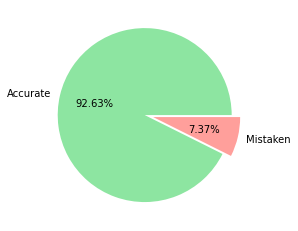

In [39]:
_, score = model.evaluate(test_ds)
colors = sns.color_palette('pastel')[2:]
accuracy_score = [score, 1 - score]
plt.pie(
    accuracy_score,
    labels=["Accurate", "Mistaken"],
    colors=colors,
    autopct=lambda val: f"{val:.2f}%",
    explode=(0.0, 0.1)
)
plt.show()

In [40]:
# ---- Confusion matrix  
#print(type(test_ds))
y_sigmoid = model.predict(test_ds) 

classe=np.argmax(y_sigmoid.logits,1)
print("predicted classe")
print(classe)

y_test = np.concatenate([y for x, y in test_ds], axis=0)
print("y_true")
print(y_test)
print("len(y_test) "+str(len(y_test)))
print("len(classe) "+str(len(classe)))

predicted classe
[0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1
 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1]
y_true
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
len(y_test

In [41]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=classe).numpy()
print(con_mat)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm)
print(con_mat_df)

[[150   7]
 [  7  26]]
      0     1
0  0.96  0.04
1  0.21  0.79


On regarde les notes, pour voir si un seuil bien choisi sur les probabilités peut améliorer l'algo

In [42]:
probabilities =  tf.nn.softmax(y_sigmoid.logits)
print("probabilities")
print(probabilities)


probabilities
tf.Tensor(
[[0.99708    0.00291996]
 [0.99783343 0.00216662]
 [0.97533053 0.02466954]
 [0.9963515  0.00364848]
 [0.9972747  0.0027253 ]
 [0.99684614 0.00315389]
 [0.99694115 0.00305887]
 [0.9974166  0.00258332]
 [0.99782974 0.00217024]
 [0.9969304  0.00306956]
 [0.27411258 0.7258875 ]
 [0.01216726 0.98783267]
 [0.9840985  0.01590154]
 [0.01499816 0.98500186]
 [0.01493527 0.9850647 ]
 [0.5389813  0.46101865]
 [0.9878335  0.0121665 ]
 [0.9896722  0.0103278 ]
 [0.9965635  0.0034365 ]
 [0.996621   0.00337894]
 [0.99785775 0.0021422 ]
 [0.9976751  0.00232491]
 [0.9842778  0.01572219]
 [0.0099162  0.9900838 ]
 [0.00984398 0.99015605]
 [0.9979139  0.00208609]
 [0.99782205 0.00217794]
 [0.99788046 0.00211959]
 [0.9979225  0.00207752]
 [0.9972584  0.0027416 ]
 [0.9976808  0.00231916]
 [0.01573377 0.9842663 ]
 [0.9961875  0.00381249]
 [0.13921425 0.8607857 ]
 [0.9902586  0.00974147]
 [0.99215287 0.00784717]
 [0.9971981  0.00280193]
 [0.9400195  0.0599805 ]
 [0.99769825 0.00230176]


In [43]:
data = {'y_Actual':   y_test,
        'y_Predicted': classe,
        'raw1': probabilities[:,0], 
        'raw2':probabilities[:,1]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted', 'raw1', 'raw2'])
print(df.to_string())





     y_Actual  y_Predicted      raw1      raw2
0         0.0            0  0.997080  0.002920
1         0.0            0  0.997833  0.002167
2         0.0            0  0.975331  0.024670
3         0.0            0  0.996351  0.003648
4         0.0            0  0.997275  0.002725
5         0.0            0  0.996846  0.003154
6         0.0            0  0.996941  0.003059
7         0.0            0  0.997417  0.002583
8         0.0            0  0.997830  0.002170
9         0.0            0  0.996930  0.003070
10        1.0            1  0.274113  0.725887
11        1.0            1  0.012167  0.987833
12        0.0            0  0.984098  0.015902
13        1.0            1  0.014998  0.985002
14        1.0            1  0.014935  0.985065
15        1.0            0  0.538981  0.461019
16        0.0            0  0.987833  0.012167
17        0.0            0  0.989672  0.010328
18        0.0            0  0.996563  0.003436
19        0.0            0  0.996621  0.003379
20        0.0

In [52]:
#mediane de raw2 quand y_Actual = 1
print("mediane "+str(df.groupby(['y_Actual'])['raw2'].median()))
print("mean "+str(df.groupby(['y_Actual'])['raw2'].mean()))
print("q25 "+str(df.groupby(['y_Actual'])['raw2'].quantile(0.25)))
print("q25 "+str(df.groupby(['y_Actual'])['raw2'].quantile(0.1)))


mediane y_Actual
0.0    0.003514
1.0    0.978286
Name: raw2, dtype: float32
mean y_Actual
0.0    0.044504
1.0    0.790997
Name: raw2, dtype: float32
q25 y_Actual
0.0    0.002583
1.0    0.742541
Name: raw2, dtype: float64
q25 y_Actual
0.0    0.002303
1.0    0.105299
Name: raw2, dtype: float64


In [44]:
df['threshold_04']=df['raw2'].apply(lambda x: 0 if x<0.4 else 1) #finalement 0.4 mis au hasard
print(df.to_string())

     y_Actual  y_Predicted      raw1      raw2  threshold_04
0         0.0            0  0.997080  0.002920             0
1         0.0            0  0.997833  0.002167             0
2         0.0            0  0.975331  0.024670             0
3         0.0            0  0.996351  0.003648             0
4         0.0            0  0.997275  0.002725             0
5         0.0            0  0.996846  0.003154             0
6         0.0            0  0.996941  0.003059             0
7         0.0            0  0.997417  0.002583             0
8         0.0            0  0.997830  0.002170             0
9         0.0            0  0.996930  0.003070             0
10        1.0            1  0.274113  0.725887             1
11        1.0            1  0.012167  0.987833             1
12        0.0            0  0.984098  0.015902             0
13        1.0            1  0.014998  0.985002             1
14        1.0            1  0.014935  0.985065             1
15        1.0           

In [45]:
con_mat = tf.math.confusion_matrix(labels=df.y_Actual, predictions=df.threshold_04).numpy()
print(con_mat)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm)
print(con_mat_df)

[[150   7]
 [  6  27]]
      0     1
0  0.96  0.04
1  0.18  0.82
